# Introduction do deep learning for computer vision

## Imports

In [39]:
import os, shutil, pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
from plot_utils import plot_history

print(f"{tf.__version__ = }")

tf.__version__ = '2.6.1'


## Introduction to covnets

In [4]:
def build_covnet():
    inputs = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_covnet()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0   

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60_000, 28, 28, 1)).astype("float32") / 255
test_images = test_images.reshape((10_000, 28, 28, 1)).astype("float32") / 255

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"{test_acc = :.3f}")

2022-04-30 23:03:58.109853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-30 23:04:04.887305: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


938/938 [==============================] - 24s 5ms/step - loss: 0.1534 - accuracy: 0.9523
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0447 - accuracy: 0.9863
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0304 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0233 - accuracy: 0.9931
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0276 - accuracy: 0.9917
test_acc = 0.992


## Training a covnet from scratch on a small dataset

### Pepare the dataset

In [14]:
home_dir = pathlib.Path.home()
original_dir= home_dir / "data/dogs-vs-cats/train"
new_base_dir = home_dir / "data/dogs-vs-cats-small"

In [23]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dst = new_base_dir / subset_name / category
        dst.mkdir(parents=True, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst= dst / fname)

make_subset("train", start_index=0, end_index=1_000)
make_subset("validation", start_index=1_000, end_index=1_500)
make_subset("test", start_index=1_500, end_index=2_500)

In [24]:
!ls -1 {new_base_dir}/train/cat | wc -l
!ls -1 {new_base_dir}/validation/cat | wc -l
!ls -1 {new_base_dir}/test/cat | wc -l

1000
500
1000


In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

2022-04-30 23:51:19.334478: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-30 23:51:19.871626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [26]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [30]:
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [29]:
for image_batch, labels_batch in train_dataset.take(1):
    print(f"{image_batch.shape = }")
    print(f"{labels_batch.shape = }")

image_batch.shape = TensorShape([32, 180, 180, 3])
labels_batch.shape = TensorShape([32])


2022-04-30 23:57:27.014707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="covnet_from_scratch.keras", save_best_only=True, monitor="val_loss")
]
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30


2022-05-01 00:00:01.199042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


63/63 [==============================] - 9s 101ms/step - loss: 0.7073 - accuracy: 0.5215 - val_loss: 0.6915 - val_accuracy: 0.5730
Epoch 2/30
63/63 [==============================] - 5s 86ms/step - loss: 0.6998 - accuracy: 0.5400 - val_loss: 0.6875 - val_accuracy: 0.5110
Epoch 3/30
63/63 [==============================] - 6s 87ms/step - loss: 0.7608 - accuracy: 0.5780 - val_loss: 0.7840 - val_accuracy: 0.5130
Epoch 4/30
63/63 [==============================] - 6s 87ms/step - loss: 0.6709 - accuracy: 0.6330 - val_loss: 0.6468 - val_accuracy: 0.6440
Epoch 5/30
63/63 [==============================] - 6s 88ms/step - loss: 0.6165 - accuracy: 0.6640 - val_loss: 0.8600 - val_accuracy: 0.5930
Epoch 6/30
63/63 [==============================] - 6s 87ms/step - loss: 0.5640 - accuracy: 0.7200 - val_loss: 1.0256 - val_accuracy: 0.5700
Epoch 7/30
63/63 [==============================] - 6s 87ms/step - loss: 0.5241 - accuracy: 0.7440 - val_loss: 0.8124 - val_accuracy: 0.6610
Epoch 8/30
63/63 [=====

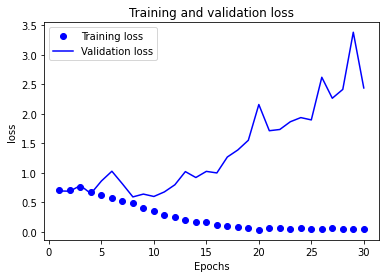

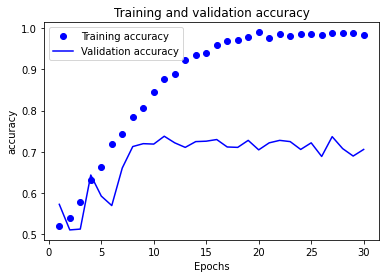

In [34]:
plot_history(history, variable_name="loss")
plot_history(history, variable_name="accuracy")

In [36]:
# load best an check test performance
test_model = keras.models.load_model("covnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"{test_acc = :.3f}")

63/63 [==============================] - 2s 27ms/step - loss: 0.5940 - accuracy: 0.7035
test_acc = 0.703


### Using data augmentation

In [37]:
# define data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

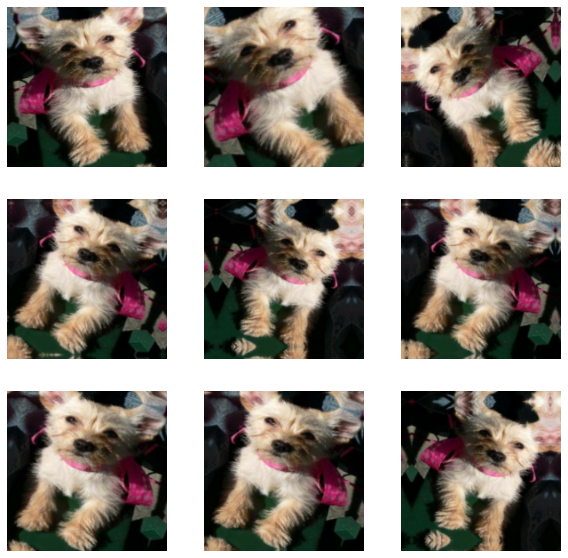

In [41]:
#display
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Epoch 1/100
63/63 [==============================] - 7s 95ms/step - loss: 0.8623 - accuracy: 0.5045 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 2/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6942 - accuracy: 0.5325 - val_loss: 0.6912 - val_accuracy: 0.5600
Epoch 3/100
63/63 [==============================] - 6s 91ms/step - loss: 0.7198 - accuracy: 0.5450 - val_loss: 0.6591 - val_accuracy: 0.5760
Epoch 4/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6833 - accuracy: 0.5860 - val_loss: 0.6894 - val_accuracy: 0.5600
Epoch 5/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6648 - accuracy: 0.5995 - val_loss: 0.6627 - val_accuracy: 0.5670
Epoch 6/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6394 - accuracy: 0.6590 - val_loss: 0.6271 - val_accuracy: 0.6520
Epoch 7/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6217 - accuracy: 0.6650 - val_loss: 0.6256 - val_accuracy: 0.6540
Epoch 

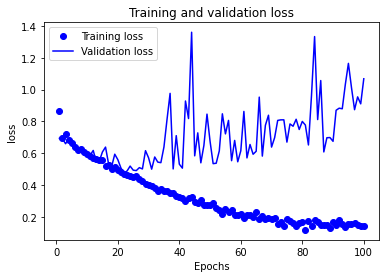

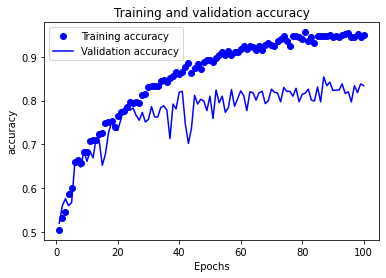

In [42]:
#same as before but with data augmentation
model_name = "covnet_from_scratch_w_aug.keras"

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, monitor="val_loss")
]
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks)
plot_history(history, variable_name="loss")
plot_history(history, variable_name="accuracy")

In [43]:
# load best an check test performance
test_model = keras.models.load_model(model_name)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"{test_acc = :.3f}")


63/63 [==============================] - 2s 27ms/step - loss: 0.5113 - accuracy: 0.7535
test_acc = 0.753


Epoch 1/100
63/63 [==============================] - 7s 99ms/step - loss: 0.7962 - accuracy: 0.5080 - val_loss: 0.6926 - val_accuracy: 0.5080
Epoch 2/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6961 - accuracy: 0.5160 - val_loss: 0.9617 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6977 - accuracy: 0.5635 - val_loss: 0.7334 - val_accuracy: 0.5400
Epoch 4/100
63/63 [==============================] - 6s 92ms/step - loss: 0.7019 - accuracy: 0.5950 - val_loss: 0.7896 - val_accuracy: 0.5070
Epoch 5/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6726 - accuracy: 0.6180 - val_loss: 0.6293 - val_accuracy: 0.6180
Epoch 6/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6637 - accuracy: 0.6480 - val_loss: 0.6066 - val_accuracy: 0.6690
Epoch 7/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6143 - accuracy: 0.6675 - val_loss: 0.6101 - val_accuracy: 0.6540
Epoch 

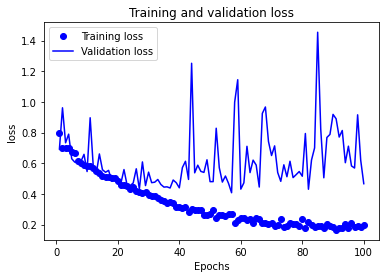

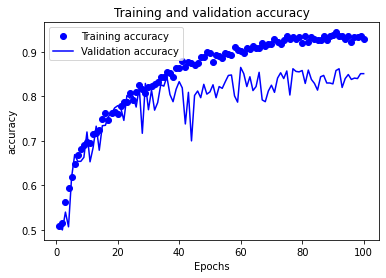

63/63 [==============================] - 2s 26ms/step - loss: 0.4878 - accuracy: 0.8265
test_acc = 0.826


In [44]:
#same as before but with drpout
model_name = "covnet_from_scratch_w_aug_and_dropout.keras"

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, monitor="val_loss")
]
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks)
plot_history(history, variable_name="loss")
plot_history(history, variable_name="accuracy")

# load best an check test performance
test_model = keras.models.load_model(model_name)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"{test_acc = :.3f}")

### Feature extraction with a pretrained model